# Advanced Modelling

Now that I have found a base model to work with, let's see how I can improve upon or build a better competing model. In this part of the project, I will be attempting to optimize the Ridge Regression base model. In addition, I will build RandomForest and Light Gradient Boosting Machine (LGBM) models and compare their performance against the optimized Ridge Regression. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import pickle
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('../capstone2-housing/documents/final_housing_df.csv', index_col=0)
X_train = pickle.load(open('X_train', 'rb'))
X_test = pickle.load(open('X_test', 'rb'))
y_train = pickle.load(open('y_train', 'rb'))
y_test = pickle.load(open('y_test', 'rb'))

model1 = pickle.load(open('RR_base', 'rb'))

Okay, now that everything has been imported, the fun can begin. First, I want to try to improve on my Ridge Regression base model. In my base modelling, I finetuned the hyperparameter alpha=0.1. I also identified the top three positive and top three negative importance features, let's retrace the steps and get a list of the top 10 coefficients.

##### Ridge Regression

In [3]:
coefs = model1.coef_
feature_dict = {}
for coef, feat in zip(coefs, X_train.columns):
    feature_dict[round(coef)] = feat

In [4]:
positive_coefs = sorted([round(coef) for coef in coefs if coef >=0], reverse=True)
negative_coefs = sorted([round(coef) for coef in coefs if coef < 0], reverse=True, key=abs)
top_pos_feat = positive_coefs[:10]
top_neg_feat = negative_coefs[:10]

print(top_pos_feat)
print(top_neg_feat)

[145606, 124965, 92548, 72769, 66604, 62588, 51464, 47327, 43907, 43710]
[-404345, -170360, -110046, -102164, -58605, -56044, -52028, -50921, -47994, -40665]


In [5]:
top_features = positive_coefs[:10] + negative_coefs[:10]
for i in top_features:
    print(feature_dict.get(i), ":", i)

Fence_GdPrv : 145606
Exterior1st_AsbShng : 124965
RoofMatl_Metal : 92548
YearBuilt_1934 : 72769
PoolQC_Fa : 66604
RoofMatl_Membran : 62588
RoofMatl_ClyTile : 51464
OverallCond_1 : 47327
RoofMatl_WdShngl : 43907
RoofStyle_Flat : 43710
RoofMatl_CompShg : -404345
Condition2_RRAe : -170360
PoolQC_Na : -110046
PoolQC_Gd : -102164
YearBuilt_1893 : -58605
GarageYrBlt_1906.0 : -56044
YearBuilt_1965 : -52028
GarageYrBlt_1933.0 : -50921
ExterCond_TA : -47994
GarageYrBlt_1920.0 : -40665


There are different ways I can approach this. For this project, I have decided to loop over a range of numbers (k) that will create a subset of the top k positive and top k negative features. I will use each subset to retrain the model with a cross-validation function and retreive the MAE and MAPE scores for each of the subsets.

First, I will rebuild a cross-validation function (built in Advanced Logistic Regression case-study for this course). That returns MAE and MAPE scores for each iteration.  
Next, I will create a function that extracts the top k features based on the model coefficients, uses the cross-validation on those features, and returns the MAE and MAPE results for each value of K.

In [6]:
def cv_score(clf, x, y, score_func=mean_absolute_error):
    #print(str(type(x)) + ' ' + str(x.shape) + ' ' + str(type(y)) + ' ' + str(y.shape))
    result_default = 0
    result_mape = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        y_pred = clf.predict(x[test])
        result_default += score_func(y_pred, y[test]) # evaluate score function on held-out data
        result_mape += np.mean(np.abs((y[test] - y_pred)/y[test]))
    return (result_default / nfold), (result_mape / nfold)

In [7]:
# function that takes a number as an input, creates a mask from two global lists (positive_coefs, negative_coefs), 
# creates a new X_train with that mask, performs cross-validation, and returns a tuple 

def k_feature_score(k):
    selected_features = []
    top_k = positive_coefs[:k] + negative_coefs[:k]
    for coef in top_k:
        selected_features.append(feature_dict.get(coef))
    X_train_k = X_train[selected_features]
    X_train_k = X_train_k.to_numpy()
    y_train_k = y_train.to_numpy()
    mae_scores, mape_scores = cv_score(model1, X_train_k, y_train_k)
    return (mae_scores, mape_scores)

Time to find the best k value. I will use my function to iterate over k values the length of the list of negative coefficients (as that list is smaller than the list of positive coefficients). I will gather the results in one list of k_value_scores.

In [8]:
iterations = len(negative_coefs)
k_value_scores = []

for num in range(1, iterations):
    cv_scores = k_feature_score(num)
    k_value_scores.append(cv_scores)
print(k_value_scores)

[(58071.7187427021, 0.36899258314607397), (58256.05498179355, 0.3683679072485024), (58277.21074712209, 0.36826808582250353), (58616.89078924405, 0.3695768130229524), (58399.37033889587, 0.3685560321865939), (58386.7862944083, 0.36855202894447625), (58551.96675143474, 0.36988967697163266), (55444.54528770454, 0.35618164459451684), (55345.44107293371, 0.3557203997967383), (55497.44291198782, 0.35582222548128184), (55513.87637112511, 0.35609932101104796), (55587.28634021359, 0.3568382639304705), (55636.37578508242, 0.35715486069836766), (55603.25741043497, 0.3566394988007596), (55529.98086508851, 0.3565144948436224), (51767.541379030634, 0.326393356380941), (51818.684610712124, 0.3263932008375601), (51987.29666734776, 0.32701809728497994), (50913.659259072614, 0.32004135489552804), (50504.75119438496, 0.31300494759027525), (50400.109309545325, 0.3125092878808913), (46745.23433217629, 0.2929675040063444), (46785.84113853068, 0.29313903264053837), (46655.42862860513, 0.2919053271905574), (4

Let's find the smallest score and it's corresponding k value (index+1)

In [9]:
best_score = min(k_value_scores)
best_k = k_value_scores.index(best_score) + 1
print(best_score, best_k)

(20817.01849296917, 0.12362469420299238) 143


Based on the MAE (20817.0185) and MAPE (0.1236) scores, the model performs best when for the top 143 features. Below, I will create the mask to select the top 143 positie and negative features, train the model with those features and summarize the scores below.

In [10]:
selected_features = []
top_k = positive_coefs[:143] + negative_coefs[:143]
for coef in top_k:
    selected_features.append(feature_dict.get(coef))
X_train_rr = X_train[selected_features]
X_test_rr = X_test[selected_features]

In [11]:
model1.fit(X_train_rr, y_train)
mod1_y_test_pred = model1.predict(X_test_rr)
mod1_r2_test = model1.score(X_test_rr, y_test)
mod1_mae_test = mean_absolute_error(y_test, mod1_y_test_pred)
mod1_mape_test = np.mean(np.abs((y_test - mod1_y_test_pred)/y_test))
print('Ridge R2 score:', mod1_r2_test, ', Ridge MAE:', mod1_mae_test, 'Ridge MAPE:', mod1_mape_test)

Ridge R2 score: 0.842780751377597 , Ridge MAE: 21112.992758626242 Ridge MAPE: 0.12425707535528599


| Model | R2 Score | MAE | MAPE |  
| --- | --- | --- | --- |  
| Baseline RR | 0.8353| 20668.8593 |  
|Feature Selection RR | 0.8428 | 21112.9928 | 0.1242 |

Above, I have completed feature selection for my Ridge Regression model. I have found that a subset of the top 143 positive and top 143 negative features scores the lowest MAPE. Compared to the baseline Ridge Regression model, using this subset of features has a better R2 score but a slightly worse MAE. 

##### Random Forest Regression

Now that I have fine tuned the Ridge Regression, let's see if there are other models that could perform better. The first one I want to try is Random Forest Regression. I will start with establishing a base model.

In [12]:
rfr = RandomForestRegressor(random_state=123)
rfr.fit(X_train, y_train)
rfr_y_train_pred = rfr.predict(X_train)
rfr_r2_train = rfr.score(X_train, y_train)
rfr_mae_train = mean_absolute_error(y_train, rfr_y_train_pred)
print('Random Forest R2 score:', rfr_r2_train, ', Random Forest 2 MAE:', rfr_mae_train)

Random Forest R2 score: 0.9778821466705006 , Random Forest 2 MAE: 6956.267291585127


In [13]:
rfr_y_test_pred = rfr.predict(X_test)
rfr_r2_test = rfr.score(X_test, y_test)
rfr_mae_test = mean_absolute_error(y_test, rfr_y_test_pred)
print('Random Forest R2 score:', rfr_r2_test, ', Random Forest 2 MAE:', rfr_mae_test)

Random Forest R2 score: 0.8525919728615938 , Random Forest 2 MAE: 18405.52422700587


Looks like the Random Forest Regressor is overfitted and needs some refining. Let's start with hyperparameter tuning. I've been using this guide to decide on which parameters to tune: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy  

I will do a grid search cross validation to see which n_estimators and min_leaf_sample score the lowest MAE. After a preliminary run through, I have decided to start the iterations at n_estimators=50, going in 10 estimator increments up to 140 estimators (anything below 50 and above 150 yielded clearly poorer results). For min_samples_leaf, I have decided to start the iterations at 5, going in 5 samples increments up to 60.

In [14]:
rfr = RandomForestRegressor(oob_score=True, n_jobs=-1, random_state=123)
params = {'n_estimators':range(50, 150, 10), 'min_samples_leaf':range(5, 65, 10)}
grid_model = GridSearchCV(rfr, param_grid=params, cv=5, scoring='neg_mean_absolute_error')
grid_model.fit(X_train, y_train)
grid_model.best_params_, grid_model.best_score_, grid_model.best_estimator_

({'min_samples_leaf': 5, 'n_estimators': 140},
 -20337.170668500148,
 RandomForestRegressor(min_samples_leaf=5, n_estimators=140, n_jobs=-1,
                       oob_score=True, random_state=123))

Looks lilke using a combination of min_samples_leaf=5 and n_estimators=140 results in the lowest MAE. Let's build the model below and see how it performs in test.

In [15]:
rfr = RandomForestRegressor(n_estimators=140, min_samples_leaf=5, oob_score=True, n_jobs=-1, random_state=123)
rfr.fit(X_train, y_train)
rfr_y_test_pred = rfr.predict(X_test)
rfr_r2_test = rfr.score(X_test, y_test)
rfr_mae_test = mean_absolute_error(y_test, rfr_y_test_pred)
rfr_mape_test = np.mean(np.abs((y_test - rfr_y_test_pred)/y_test))
print('TEST R2:', rfr_r2_test, ', MAE:', rfr_mae_test, 'MAPE:', rfr_mape_test)

TEST R2: 0.826766542901784 , MAE: 19127.3625817715 MAPE: 0.10956888426231229


Above, I have fine tuned the parameters for the Random Forest Regressor. We have a test R2 score of 0.8268 and MAE of 19127.3626. Slightly better MAE than my Ridge Regression model. Would feature selection be able to improve the performance even more?  
For feature selection, I will be using the method SelectFromModel (with the parameters discussed in this article: https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f) to do my feature selection.  
  
First, I want to check out the feature importances from the model.

In [16]:
rfr.feature_importances_

array([3.29897980e-03, 9.62941025e-03, 1.21303560e-02, 4.81258352e-02,
       1.87703803e-04, 4.52227985e-03, 6.20263521e-02, 4.00043053e-02,
       6.42809955e-03, 0.00000000e+00, 1.87021584e-01, 5.65478091e-04,
       4.49387939e-06, 2.18701413e-02, 1.51033205e-03, 2.77478558e-03,
       2.01419954e-03, 1.53801809e-02, 3.41817463e-01, 1.93207498e-02,
       4.33383090e-03, 3.76978492e-03, 3.23994758e-04, 0.00000000e+00,
       3.02122934e-04, 0.00000000e+00, 0.00000000e+00, 1.14938496e-03,
       1.49268065e-03, 4.87228838e-04, 8.27075705e-04, 0.00000000e+00,
       0.00000000e+00, 1.54364592e-04, 3.95247577e-03, 7.43085936e-05,
       0.00000000e+00, 3.75511465e-05, 0.00000000e+00, 1.90652557e-05,
       5.45982243e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.77412298e-06, 0.00000000e+00, 8.80642770e-04,
       7.79513969e-04, 0.00000000e+00, 0.00000000e+00, 1.11972824e-05,
       9.95709584e-06, 3.76782724e-06, 4.02184711e-04, 0.00000000e+00,
      

Looks like there are a lot of features that have 0 importance. I started with a feature selection of everything above 0, and after playing around with the different values, I found that using a feature importance threshold 0.0000001 slightly improves the model. 

In [17]:
sel = SelectFromModel(rfr, threshold=0.0000001)
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

202
Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       ...
       'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'MiscFeature_Gar2',
       'SaleType_CWD', 'SaleType_Oth', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Partial', 'YearSold'],
      dtype='object', length=202)


I will use the 202 features with the highest importance for this model printed above to create new X_train/X_test sets and retrain the model.

In [18]:
# rfr_mape_test calculates the mean average percentage error
X_train_rfr = X_train[selected_feat]
X_test_rfr = X_test[selected_feat]

rfr.fit(X_train_rfr, y_train)
rfr_y_test_pred = rfr.predict(X_test_rfr)
rfr_r2_test = rfr.score(X_test_rfr, y_test)
rfr_mae_test = mean_absolute_error(y_test, rfr_y_test_pred)
rfr_mape_test = np.mean(np.abs((y_test - rfr_y_test_pred)/y_test))
print('TEST R2:', rfr_r2_test, ', MAE:', rfr_mae_test, 'MAPE:', rfr_mape_test)

TEST R2: 0.8269043351422135 , MAE: 19113.826673566284 MAPE: 0.10953477994107555


Selecting a subset of the 20 features with the highest importance slightly improved the performance of the model. The best Random Forest Regression performance scores that I have found in this part of the project are:  
R2: 0.7594 and MAE: 22925.2674  
Let's add that to my comparison, before moving on to LGBM.

| Model | R2 Score | MAE | MAPE |  
| --- | --- | --- | --- |  
| Baseline RR | 0.8353| 20668.8593 |  
| Feature Selection RR | 0.8428 | 21112.9928 | 0.1242 |  
| Baseline RFR | 0.8526 | 18405.5242 |
| Hyperparameter RFR | 0.8268 | 19127.3626 | --- | 
| Feature Selection RFR | 0.8269 | 19113.8267 | 0.1095 |  

##### Light Gradient Boosted Machine Algorithm (LGBM)

So far, I have built a Ridge Regression model and a Random Forest model. The Ridge Regression model is currently the best performing one.  
Finally, I want to build a LGBM model to see if that model could outperform my Ridge Regression. As before, I will begin with building a base model, training and testing it on the data as is. For this part of the project, I have been using this site as a guide: https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

In [19]:
lgbm = LGBMRegressor(random_state=123)
lgbm.fit(X_train, y_train)
lgbm_y_train_pred = lgbm.predict(X_train)
lgbm_r2_train = lgbm.score(X_train, y_train)
lgbm_mae_train = mean_absolute_error(y_train, lgbm_y_train_pred)
print('TRAIN R2:', lgbm_r2_train, ', MAE:', lgbm_mae_train)

TRAIN R2: 0.9776385877338646 , MAE: 5647.614989434855


In [20]:
lgbm_y_test_pred = lgbm.predict(X_test)
lgbm_r2_test = lgbm.score(X_test, y_test)
lgbm_mae_test = mean_absolute_error(y_test, lgbm_y_test_pred)
print('TEST R2:', lgbm_r2_test, ', MAE:', lgbm_mae_test)

TEST R2: 0.8507357166979355 , MAE: 17327.200122753264


The train and test results show that the model is overfitted. Let's see if that can be fixed by hyperparameter tuning. I will tune the parameters num_leaves and min_child_samples (to prevent overfitting). As before, I will iterate over a range of possible values (in incfrements of ten) and find which combination performs the best based on their MAE score.

In [21]:
lgbm = LGBMRegressor(num_leaves=i, random_state=123)
params = {'num_leaves':range(10, 160, 10), 'min_child_samples':range(10, 300, 10)}
grid_model = GridSearchCV(lgbm, param_grid=params, cv=5, scoring='neg_mean_absolute_error')
grid_model.fit(X_train, y_train)
grid_model.best_params_, grid_model.best_score_, grid_model.best_estimator_

({'min_child_samples': 30, 'num_leaves': 10},
 -18134.492048100907,
 LGBMRegressor(min_child_samples=30, num_leaves=10, random_state=123))

Using num_leaves=10 and min_child_samples=30 seems to be the best combination. Let's rebuild the model below.

In [22]:
lgbm = LGBMRegressor(num_leaves=10, min_child_samples=30, random_state=123)
lgbm.fit(X_train, y_train)
lgbm_y_train_pred = lgbm.predict(X_train)
lgbm_r2_train = lgbm.score(X_train, y_train)
lgbm_mae_train = mean_absolute_error(y_train, lgbm_y_train_pred)
print('TRAIN R2:', lgbm_r2_train, ', MAE:', lgbm_mae_train)
lgbm_y_test_pred = lgbm.predict(X_test)
lgbm_r2_test = lgbm.score(X_test, y_test)
lgbm_mae_test = mean_absolute_error(y_test, lgbm_y_test_pred)
print('TEST R2:', lgbm_r2_test, ', MAE:', lgbm_mae_test)

TRAIN R2: 0.9480475575523535 , MAE: 11114.138353166909
TEST R2: 0.8677917704363621 , MAE: 16973.465692653655


Now that I have tuned some of the parameters, I will take a look at feature importance. I will recreate the steps I did for feature importance for my random forest model.

In [23]:
lgbm.feature_importances_

array([32, 49, 10, 50,  0, 17, 52, 45, 23,  0, 90,  1,  0,  4,  6, 11, 10,
       13, 27, 47, 14, 26,  1,  0,  6,  0,  0,  2,  6,  0,  4,  0,  0,  0,
        4,  4,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  1,  0,  0,
        0,  0,  0,  2,  1,  0,  1, 11,  4,  0,  2,  0,  0,  0,  5,  0,  0,
        2,  0,  1,  0,  0,  0,  0,  5,  0,  0, 11,  6,  0,  0,  0,  0,  0,
        0,  0, 13,  4,  1,  0,  0,  0, 15,  0,  0,  0,  0,  0, 11,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,
        0,  0,  2,  0,  0,  0,  0,  1,  0,  0,  0,  3,  1,  1, 10, 11,  4,
        0,  0,  0,  0,  3,  6,  1, 15,  9,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [24]:
feature_sel = []
feature_scores = []

for i in range(1, 91):
    lgbm = LGBMRegressor(num_leaves=10, min_child_samples=30, random_state=123)
    sel = SelectFromModel(lgbm, threshold=i)
    sel.fit(X_train, y_train)
    selected_feat= X_train.columns[(sel.get_support())]
    feature_sel.append(selected_feat)
    X_train_lgbm = X_train[selected_feat]
    cv_scores = cross_val_score(lgbm, X_train_lgbm, y_train, cv=5, scoring='neg_mean_absolute_error')
    feature_scores.append(np.mean(np.abs(cv_scores)))

In [25]:
best_feature_scores = min(feature_scores)
best_index = feature_scores.index(best_feature_scores)
best_features = feature_sel[best_index]

print('Best MAE:', best_feature_scores, ', Best number of features', len(best_features), ', Best Features:', best_features)

Best MAE: 17921.964540403253 , Best number of features 72 , Best Features: Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', '3SsnPorch',
       'MSSubClass_20', 'MSSubClass_40', 'MSSubClass_70', 'MSSubClass_75',
       'MSZoning_RM', 'LandContour_HLS', 'LandContour_Low', 'LotConfig_FR2',
       'Neighborhood_ClearCr', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_StoneBr',
       'Condition1_PosA', 'OverallQual_5', 'OverallQual_8', 'OverallQual_9',
       'OverallQual_10', 'OverallCond_5', 'OverallCond_6', 'OverallCond_8',
       'OverallCond_9', 'YearBuilt_2008', 'YearRemodAdd_1951',
       'Exterior1st_CBlock', 'Exterior2nd_HdBoard', 'ExterQual_Fa',
       'ExterCond_Ex', 'Foundation_BrkTil',

Looks like we get the lowest MAE when using the 72 features listed above. Below, I will create a mask for these features and rebuild, fit and evaluate the model.

In [26]:
X_train_lgbm = X_train[best_features]
X_test_lgbm = X_test[best_features]

lgbm = LGBMRegressor(num_leaves=10, min_child_samples=30, random_state=123)
lgbm.fit(X_train_lgbm, y_train)
lgbm_y_test_pred = lgbm.predict(X_test_lgbm)
lgbm_r2_test = lgbm.score(X_test_lgbm, y_test)
lgbm_mae_test = mean_absolute_error(y_test, lgbm_y_test_pred)
lgbm_mape_test = np.mean(np.abs((y_test - lgbm_y_test_pred)/y_test))
print('TEST R2:', lgbm_r2_test, ', MAE:', lgbm_mae_test, 'MAPE:', lgbm_mape_test)

TEST R2: 0.8668760322854312 , MAE: 16921.672259103663 MAPE: 0.09296230869131512


Above, I have built an LGBM, performed a GridSearchCV hyperparameter tuning that found the best combination of num_leaves (10) and min_child_samples (30), and completed cross-validation that concluded that the 72 features (listed below cell XXXX) contribute to the best performance of the model. Let's combine those findings in my comparison table below.

##### Model Score Comparison table:  
  

| Model | R2 Score | MAE | MAPE |  
| --- | --- | --- | --- |  
| Baseline RR | 0.8353| 20668.8593 |  
| Feature Selection RR | 0.8428 | 21112.9928 | 0.1242 |  
| Baseline RFR | 0.8526 | 18405.5242 |  
| Hyperparameter RFR | 0.8268 | 19127.3626 |  
| Feature Selection RFR | 0.8269 | 19113.8267 | 0.1095 |  
| Baseline LGBM | 0.8507 | 17327.2001 |    
| Hyperparameter LGBM | 0.8678 | 16973.4657 |  
| Feature Selection LGBM | 0.8669 | 16921.6723 | 0.0930 |  

Looking at the above comparison, the LGBM model (with finetuned hyperparameters and selected features) performs better than both the Ridge Regression and Random Forest Regression models. Below, I will calculate the upper and lower bound test-residuals for this model and summarize my findings.

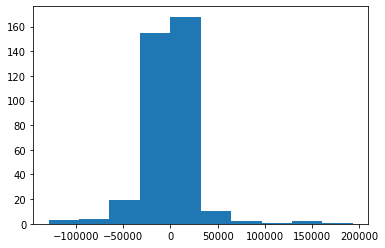

In [28]:
lgbm_test_residuals = y_test - lgbm_y_test_pred
_ = plt.hist(lgbm_test_residuals)

In [29]:
half_k = int(len(lgbm_test_residuals)*0.95 / 2)
print(len(lgbm_test_residuals), half_k)
sorted_pos = sorted([resid for resid in lgbm_test_residuals if resid >= 0])
sorted_neg = sorted([abs(resid) for resid in lgbm_test_residuals if resid < 0])
test_residuals_pos = sorted_pos[0:half_k]
test_residuals_neg = sorted_neg[0:half_k]
print(len(test_residuals_pos), len(test_residuals_neg))

365 173
173 173


In [30]:
worst_lower = max(test_residuals_pos)
worst_upper = max(test_residuals_neg)
print(round(worst_lower, 2), round(worst_upper, 2))

44272.87 54397.84


Above, I have calculated the 95% confidence interval of the residuals, then extracted the positive and negative residuals within the 95% confidence interval, and identified the worst lower case and worst upper case scenario of residuals. In the worst case scenarios, the prediction will be 44272.87 below or 54397.84 above the actual value.
To correct these errors, the worst case lower bound value should be added to, and the worst case upper bound should be subtracted from the model prediction.

###### LGBM SUMMARY

| Model | R2 Score | MAE | MAPE | Upper/Lower bound |  
| ---- | ---- | ---- | ---- | ---- |  
| LGBM | 0.8669 | 16921.6723 | 0.0930 | 54397.84/44272.87 |  
  
  
Hyperparameters: num_leaves=10, min_child_samples=30   
Number of features: 72  
List of features: 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', '3SsnPorch',
       'MSSubClass_20', 'MSSubClass_40', 'MSSubClass_70', 'MSSubClass_75',
       'MSZoning_RM', 'LandContour_HLS', 'LandContour_Low', 'LotConfig_FR2',
       'Neighborhood_ClearCr', 'Neighborhood_Edwards', 'Neighborhood_Gilbert',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_StoneBr',
       'Condition1_PosA', 'OverallQual_5', 'OverallQual_8', 'OverallQual_9',
       'OverallQual_10', 'OverallCond_5', 'OverallCond_6', 'OverallCond_8',
       'OverallCond_9', 'YearBuilt_2008', 'YearRemodAdd_1951',
       'Exterior1st_CBlock', 'Exterior2nd_HdBoard', 'ExterQual_Fa',
       'ExterCond_Ex', 'Foundation_BrkTil', 'BsmtQual_Fa', 'BsmtQual_Na',
       'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtExposure_Av', 'BsmtExposure_Mn',
       'BsmtFinType1_BLQ', 'BsmtFinType1_LwQ', 'HeatingQC_Fa', 'CentralAir_Y',
       'KitchenQual_Fa', 'KitchenQual_TA', 'Functional_Maj1', 'FireplaceQu_Ex',
       'FireplaceQu_Na', 'GarageType_Basment', 'GarageFinish_Na',
       'PavedDrive_N', 'SaleType_Oth', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Partial', 'YearSold']

##### Advanced Modelling Summary    
  
In this step of the project, I have fine-tuned and performed feature selection on my Ridge Regression model from the baseline modelling. I have also built, hyper parameter tuned, and performed feature selection on a Random Forest Regression model and a Light Gradient Boosting Model. I found that the LGBM performs the best when using hyperparameters num_leaves=10, min_child_samples=30, and the 72 features listed above.  